In [5]:
from architecture import restore_model, get_model
from torchvision import datasets, transforms
from PIL import Image

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

torch.manual_seed(1234)
np.random.seed(1234)

In [6]:
# Load the model and test dataset

def data_process(batch_size=64):
    """
    Preprocess the dataset
    Args:
        batch_size (int): number of each mini batch.
    Returns:
        dataloader (torch DataLoader): the data loader for test dataset
    """
    data_transforms =  transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    ])
                                 
    image_datasets = datasets.ImageFolder("dataset", data_transforms) 


    dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                              shuffle=False)
    
    dataset_size = len(image_datasets) 
    class_names = image_datasets.classes
    
    print("All class names from 0 to 9: ", class_names)
    print("Size of dataset: ", dataset_size)
    return dataloader

# Load the model (neural networks) with pre-trained weights
# The model contains Drpout layers so eval() is used for evaluation
model = get_model().eval()
model.load_state_dict(torch.load('vgg_face.pt', map_location='cpu'))

# Set the data loader for the test data
test_batchsize = 10
test_loader = data_process(test_batchsize)

All class names from 0 to 9:  ['a_j__buckley', 'a_r__rahman', 'aamir_khan', 'aaron_staton', 'aaron_tveit', 'aaron_yoo', 'abbie_cornish', 'abel_ferrara', 'abigail_breslin', 'abigail_spencer']
Size of dataset:  10


# Problem 1: Warming up

In [7]:
# Evaluate the face recognition system on clean data

def evaluate_clean(model, test_loader):
    """
    Evaluate the accuracy on data returned by test_loader.
    Args:
        model (torch model): the classification model.
        test_loader (DataLoader): the dataloader for test data.
    Returns:
        accuracy (float or one-element tensor): percentage of correctly classified samples in test loader.
    """
    correct = 0
    total = 0

    for X, y in test_loader:
        X = X[:,[2,1,0],:,:] # RGB to BGR (very important)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        
    accuracy =  correct / total
    # Add your code here
    
    
    return accuracy

accu_clean = evaluate_clean(model, test_loader) 
print("Accuracy on clean data: {}".format(accu_clean))

Accuracy on clean data: 1.0


# Problem 2: Eyeglass Frame Attack

Accuracy on eyeglass frame attack: 0.0
Show the images...


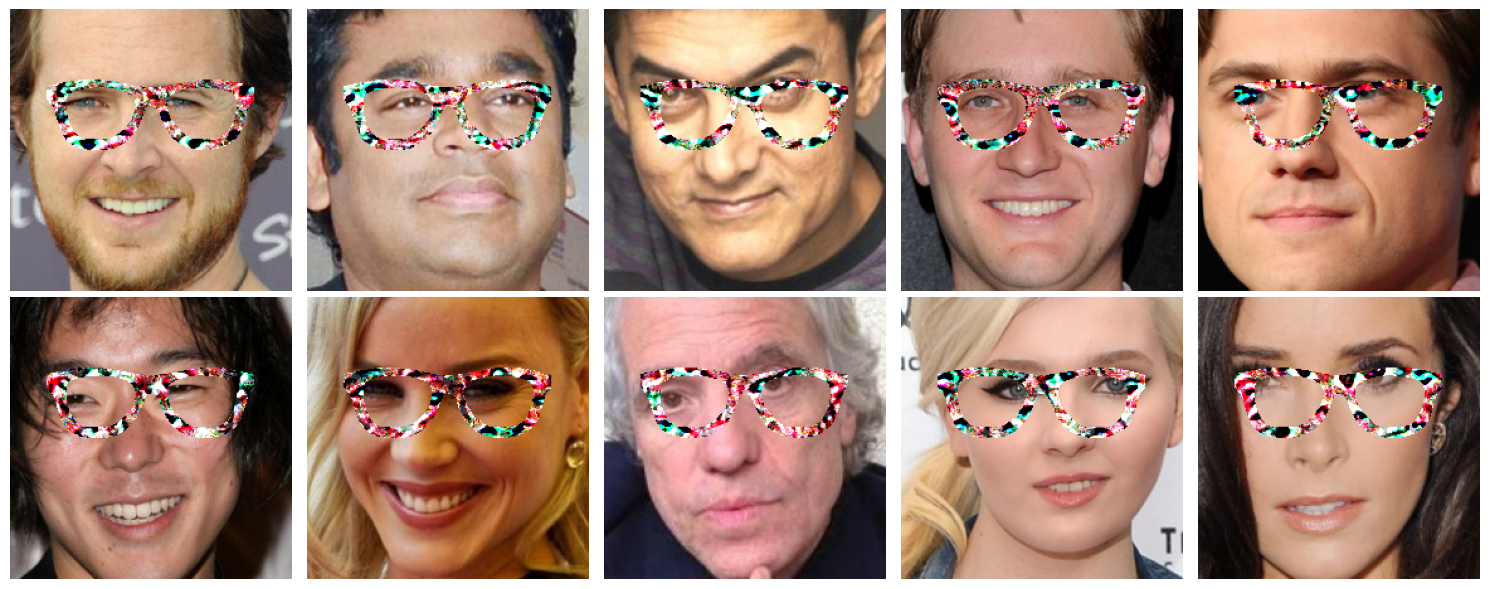

In [8]:
def plot_sample(X, M, N):
    """
    Plot a subset of a dataset given the tensor of the feature vectors and labels.
    """
    
    #%matplotlib inline

    print("Show the images...")
    f,ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N*3, M*3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(X[i*N+j].cpu().detach().numpy().transpose((1, 2, 0)))
            ax[i][j].set_axis_off()
    plt.tight_layout()
    # plt.show();

def load_eyeglass_mask():
    """
    Load the mask for eyeglass frame attack. 
    Returns:
        mask (torch.tensor): the mask. Size: 3*224*224.
    """
    
    mask = np.array(Image.open("eyeglass_mask.png"))/255. # Read the image, the format is channel last
    mask = np.moveaxis(mask, 2, 0) # Channel last to channel first (default format in pytorch)
    mask = torch.from_numpy(mask).float() # From numpy to torch.tensor
    return mask
    
    
def eyeglass_batch(model, X, y, mask, epsilon, alpha, step):
    """
    Produce perturbations of eyeglass frame attack for a given mini-batch of input (X, y) and mask.
    Args:
        model (torch model): the classification model.
        X (torch.tensor): the mini-batch of images. Dimension: batch_size*3*224*224.
        y (torch.tensor): the trues label of X.
        mask (torch.tensor): the mask. Dimension: 3*224*224.
        epsilon (float): the limit on the perturbation. Pixel values of perturbation 
                         should be in the interval (-epsilon, epsilon). 
        alpha (float): the stepsize.
        step (int): number of steps.
    Returns:
        delta.detach() (torch.tensor): the detach() method of the perturbation delta.
    """
    
    # Initialize the perturbation delta to have zeros as its elements.
    # delta should have the same size with X.
    delta = torch.zeros_like(X, requires_grad=True)
    

    for t in range(step): 
        pred = model(X + delta)
        loss = nn.CrossEntropyLoss()(pred, y)
        loss.backward(retain_graph=True)

        delta.data = delta + (alpha * delta.grad.detach().sign()).clamp_(-epsilon, epsilon)
        delta.data = delta.data * mask
        
        delta.data = torch.min(torch.max(delta.detach(), -X), 1-X)
        delta.grad.zero_()
    
    
    
    # Add you code here
    
    # Note that delta should be clipped such that X+delta lies in the [0,1] range.
    # That is, delta should lies in the [-X, 1-X] range. Note that this is a separate requirement from
    # the limit on the perturbation set by epsilon.
    return delta.detach()

def evaluate_eyeglass(model, test_loader, eyeglass_mask, epsilon=1.0, alpha=0.2, step=10):
    """
    Evaluate the eyeglass frame attack on data returned by test_loader.
    Args:
        model (torch model): the classification model.
        test_loader(Data Loader): the dataloader for test data.
        mask (torch.tensor): the mask. Dimension: 3*224*224.
        epsilon (float): the limit on the perturbation. Pixel values of perturbation 
                         should be in the interval (-epsilon, epsilon). 
        alpha (float): the stepsize.
        step (int): number of steps.
    Returns:
        X_adv (torch.tensor): the tensor of the adversarial examples of test data. Size:30*3*224*224.
        accuracy (float or one-element tensor): the accuracy of model on adversarial examples.
    """

    X_adv = torch.empty((30,3,224,224))
    total = 0
    correct = 0

    for batch_idx, (X, y) in enumerate(test_loader):
        X = X[:,[2,1,0],:,:]
        delta = eyeglass_batch(model, X, y, eyeglass_mask, epsilon, alpha, step)

        deltaX = delta + X
        X_adv.data = deltaX

        # Add you code here
        temp = model(deltaX)
        _, predicted = torch.max(temp.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        
    accuracy =  correct / total
    
    return X_adv, accuracy

# Get the adversarial examples
# Compute the accuracy on these 
mask = load_eyeglass_mask()
X_eyeglass, accu_eyeglass = evaluate_eyeglass(model, test_loader, mask,
                                              1.0, 0.2, 10)

print("Accuracy on eyeglass frame attack: {}".format(accu_eyeglass))
# Plot the adversarial examples
# Convert from BGR to RGB, this is a requirement of matplotlib
plot_sample(X_eyeglass[:,[2,1,0],:,:], 2, 5)

# Problem 3: Occlusion Attack

Accuracy on occlusion attack: 0.0
Show the images...


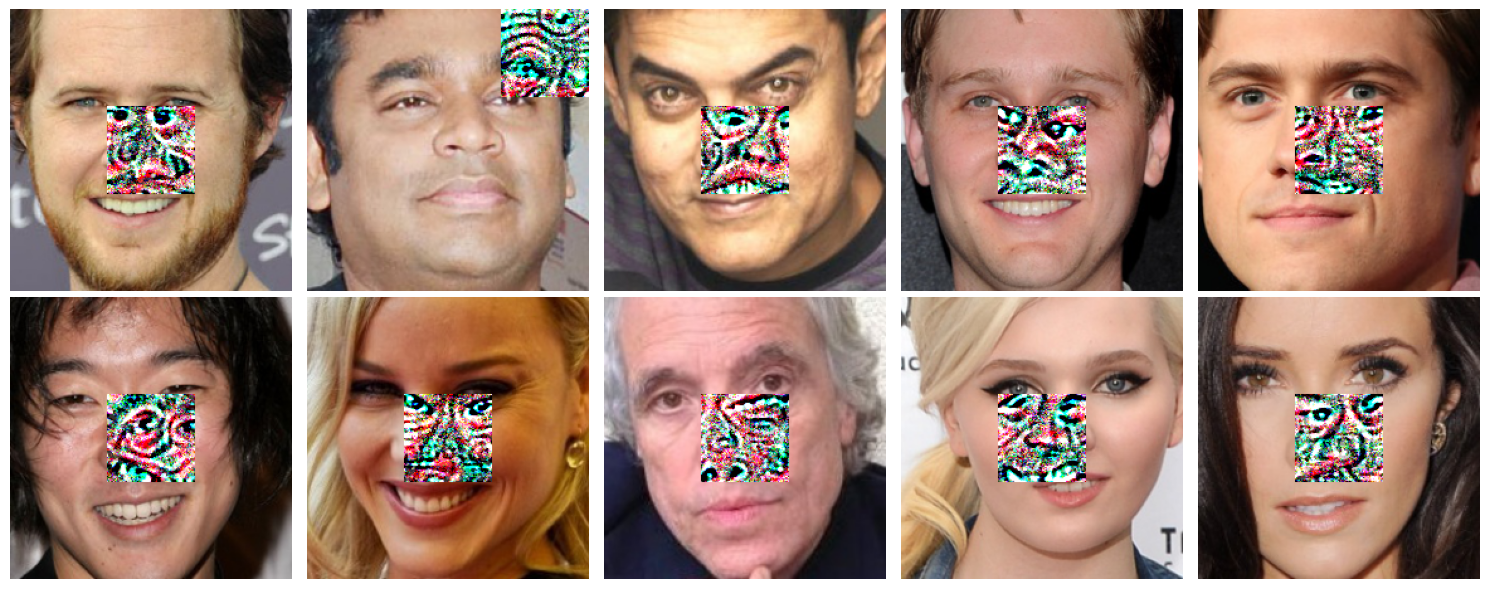

In [13]:
def occlusion_mask(idx):
    """
    Return the mask used for occlusion attack based on the index.
    idx = 0: upper left corner
    idx = 1: upper right corner
    idx = 2: lower left corner
    idx = 3: lower right corner
    idx = 4: center
    The occlosion region should have 70*70 pixels.
    Args:
        idx (int): index of the mask.
    returns:
        mask (torch.tensor): occlusion mask based on the index. Size: 3*224*224.
    """
    mask = torch.zeros((3, 224, 224))

    # Add you code here
    if idx == 0:
        mask[:, 0:70, 0:70] = 1
    elif idx == 1:
        mask[:, 0:70, 154:224] = 1
    elif idx == 2:
        mask[:, 154:224, 0:70] = 1
    elif idx == 3:
        mask[:, 154:224, 154:] = 1
    elif idx == 4:
        mask[:, 77:147, 77:147] = 1
    
    return mask

def occlusion_batch(model, X, y, epsilon, alpha, step):
    """
    Produce perturbations ofocclusion attack for a given mini-batch of input (X, y).
    The mask that results in the maximum loss among the 5 options is selected.
    Args:
        model (torch model): the classification model.
        X (torch.tensor): the mini-batch of images. Dimension: batch_size*3*224*224.
        y (torch.tensor): the trues label of X.
        epsilon (float): the limit on the perturbation. Pixel values of perturbation 
                         should be in the interval (-epsilon, epsilon). 
        alpha (float): the stepsize.
        step (int): number of steps.
    Returns:
        max_delta (torch.tensor): the perturbation that has the max loss compared to those using different masks.    
    """

    # Add your code here
    # Note that delta should be clipped such that X+delta lies in the [0,1] range.
    # That is, delta should lies in the [-X, 1-X] range. Note that this is a separate requirement from
    # the limit on the perturbation set by epsilon.

    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(5):
        mask = occlusion_mask(i)
        # Produce perturbations based on the mask, just like you did in the eyeglass_batch
        # You should select the optimal perturbation once all the five adversarial examples are produced 
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        # If you use nn.CrossEntropyLoss, be careful with the reduction parameter - you want to set it to None
        # to avoid reducing the output 
        for t in range(step):
            loss = nn.CrossEntropyLoss()(model(X + delta), y)
            loss.backward()
            delta.data =  delta + (alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
            delta.data = delta.detach() * mask
            delta.data = torch.min(torch.max(delta.detach(), -X), 1-X )
            delta.grad.zero_()

        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
    
    return max_delta    
    
def evaluate_occlusion(model, test_loader, epsilon=1.0, alpha=0.2, step=10):
    """
    Evaluate the occlusion attack on data returned by test_loader.
    Args:
        model (torch model): the classification model.
        test_loader(Data Loader): the dataloader for test data.
        epsilon (float): the limit on the perturbation. Pixel values of perturbation 
                         should be in the interval (-epsilon, epsilon). 
        alpha (float): the stepsize.
        step (int): number of steps.
    Returns:
        X_adv (torch.tensor): the tensor of the adversarial examples of test data. Size:30*3*224*224.
        accuracy (float or one-element tensor): the accuracy of model on adversarial examples.
    """
    X_adv = torch.empty((30,3,224,224))
    correct = 0
    total = 0
    
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X[:,[2,1,0],:,:]
        delta = occlusion_batch(model, X, y, epsilon, alpha, step)
        
        # Add your code here
        deltaX = delta + X
        X_adv.data = deltaX

        total += y.size(0)
        temp = model(deltaX)
        _, predicted = torch.max(temp.data, 1)
        correct += (predicted == y).sum().item()
    
    accuracy = correct/total
            
    return X_adv, accuracy

# Get the adversarial examples
# Compute the accuracy on these
X_occlusion, accu_occlusion = evaluate_occlusion(model, test_loader, 1.0, 0.2, 10)
print("Accuracy on occlusion attack: {}".format(accu_occlusion))

# Plot the adversarial examples
# Convert from BGR to RGB, this is a requirement of matplotlib
plot_sample(X_occlusion[:,[2,1,0],:,:], 2, 5)

Your answer to the questions:

1. In Q3 relating to the occlusion attack, the occlusions are positioned for the most part in the middle region of the input image. The ROA attack finds a position in which it can maximize prediction error (aka loss) over the image. This means that placing the occlusion in the middle region of the image is the best place to obscure the face have the results misclassified. 

2. To prevent against adversarial attacks, we can use adversarial training. This is done through continously incrementing learning by adding adversial examples until convergence or for a fixed number of epochs. Since we know that training creates succeptible neural networks, we can also train the network on a few adversarial examples. While training might result in a slight decrement in the accuracy of the model's prediction, this tradeoff is justified becuase it makes it more robust against adversarial attacks. Robustness refers to a model's ability to defend against attacks, so adversarial training would increase the robustness and suceptibility of a model.